In [1]:
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import tarfile

In [2]:
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(dataset_url, '.')

100%|██████████| 135107811/135107811 [00:02<00:00, 50469008.03it/s]


In [3]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path='./data')

In [4]:
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir+"/train")
print(classes)

['train', 'test']
['automobile', 'dog', 'deer', 'frog', 'horse', 'ship', 'airplane', 'truck', 'cat', 'bird']


In [5]:
frog_images=os.listdir(data_dir+'/train/frog')
print(len(frog_images))
print(frog_images[:5])

5000
['4919.png', '4115.png', '4738.png', '2436.png', '3009.png']


In [6]:
print(len(os.listdir(data_dir+'/test/frog')))

1000


In [7]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [8]:
dataset = ImageFolder(data_dir+'/train', transform = ToTensor())

torch.Size([3, 32, 32]) 0


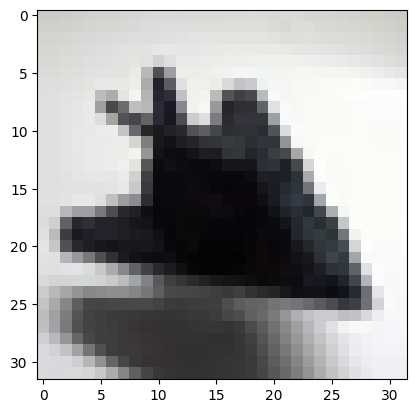

In [9]:
img, label = dataset[0]
print(img.shape, label)
plt.imshow(img.permute(1,2,0))

In [10]:
len(dataset)

50000

In [11]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [12]:
def show_example(img, label):
  print('Label:'+ dataset.classes[label]+' -- '+str(label))
  plt.imshow(img.permute(1,2,0))

Label:airplane -- 0


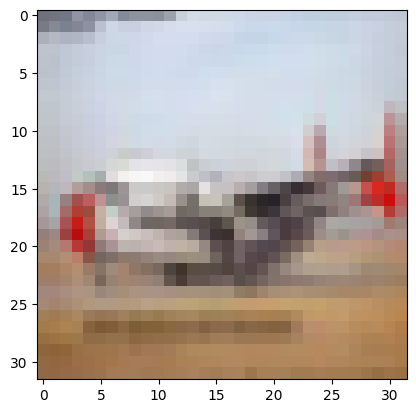

In [13]:
im, lbl = dataset[1099]
show_example(im, lbl)

Label:automobile -- 1


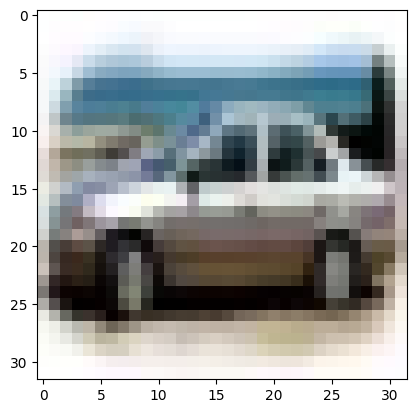

In [14]:
# other way
show_example(*dataset[9524])

In [15]:
random_seed = 25
torch.manual_seed(random_seed)

In [16]:
val_size = 5000
train_size = len(dataset)-val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [17]:
from torch.utils.data.dataloader import DataLoader

In [79]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)

# we can use double batch size for validation as for validation set,
# we will not be calculating gradients and thus, would easily handle bigger batches
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [19]:
from torchvision.utils import make_grid

In [20]:
def show_batch(dl):
  for images, lb in dl:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]);
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


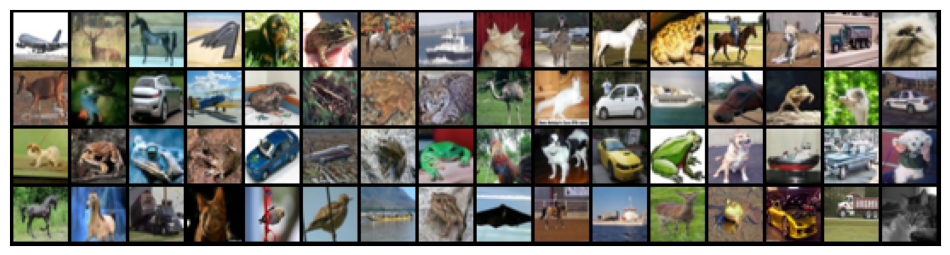

In [21]:
show_batch(train_dl)

In [23]:
#lets manually try a single convolution operation
def apply_kernel(image, kernel):
  ri, ci = image.shape       # image dimensions
  rk, ck = kernel.shape      # kernel dimensions
  ro, co = ri-rk+1, ci-ck+1  # output dimensions
  output = torch.zeros([ro, co])
  for i in range(ro):
    for j in range(co):
      output[i, j] = torch.sum(image[i:i+rk, j:j+ck] * kernel)
  return output

In [24]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0],
    [0, 0, 1, 3, 1],
    [3, 1, 2, 2, 3],
    [2, 0, 0, 2, 2],
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2],
    [2, 2, 0],
    [0, 1, 2]
], dtype=torch.float32)

apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

In [25]:
import torch.nn as nn
import torch.nn.functional as F

In [26]:
# sample of a 2 layered model
temp_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size = 3, stride = 1, padding = 1),
    nn.MaxPool2d(2, 2)
)

In [27]:
for img, lbl in train_dl:
  print(img.shape)
  print(temp_model(img).shape)
  break

torch.Size([64, 3, 32, 32])
torch.Size([64, 8, 16, 16])


In [28]:
class ImageClassificationBaseClass(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss':loss, 'val_acc':acc}

  def validation_epoch_end(self, out):
    batch_losses = [x['val_loss'] for x in out]
    batch_accs = [x['val_acc'] for x in out]
    return {
        'val_loss': torch.stack(batch_losses).mean().item(),
        'val_acc': torch.stack(batch_accs).mean().item()
        }

  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [29]:
def accuracy(out, labels):
  _, preds = torch.max(out, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [30]:
class Cifar10CnnModel(ImageClassificationBaseClass):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

  def forward(self, xb):
    return self.network(xb)

In [55]:
from torchinfo import summary

model=Cifar10CnnModel()

model.to('cuda')
summary(model, input_size=(10, 3, 32, 32), verbose=0, col_names=["input_size", "output_size", "num_params", "mult_adds"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
Cifar10CnnModel                          [10, 3, 32, 32]           [10, 10]                  --                        --
├─Sequential: 1-1                        [10, 3, 32, 32]           [10, 10]                  --                        --
│    └─Conv2d: 2-1                       [10, 3, 32, 32]           [10, 32, 32, 32]          896                       9,175,040
│    └─ReLU: 2-2                         [10, 32, 32, 32]          [10, 32, 32, 32]          --                        --
│    └─Conv2d: 2-3                       [10, 32, 32, 32]          [10, 64, 32, 32]          18,496                    189,399,040
│    └─ReLU: 2-4                         [10, 64, 32, 32]          [10, 64, 32, 32]          --                        --
│    └─MaxPool2d: 2-5                    [10, 64, 32, 32]          [10, 64, 16, 16]          --                        --
│

In [59]:
from torch.profiler import profile, record_function, ProfilerActivity

def profile_model():
    inputs = next(iter(train_dl))[0].to('cuda')

    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
        with record_function("model_inference"):
            model(inputs)

    print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

profile_model()


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference        11.32%     924.000us        68.38%       5.580ms       5.580ms       0.000us         0.00%       5.640ms       5.640ms             1  
                                           aten::conv2d         0.62%      51.000us        46.10%       3.762ms     627.000us       0.000us         0.00%       4.509ms     751.500us             6  
         

In [67]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl=dl
    self.device=device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [68]:
device = torch.device('cpu')
if torch.cuda.is_available():
  device = torch.device('cuda')

In [69]:
for images, labels in train_dl:
  print(images.shape)
  print(model(images.to(device)).shape)
  break

torch.Size([64, 3, 32, 32])
torch.Size([64, 10])


In [70]:
#transfer data to GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [71]:
# transfer the model to GPU
model = to_device(Cifar10CnnModel(), device)

In [72]:
def evaluate(model, val_loader):
  model.eval()
  out = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(out)

In [73]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
  hist=[]
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    model.train() # this notifies that model is going to training phase
    train_losses = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    res = evaluate(model, val_loader)
    res['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, res)
    hist.append(res)
  return hist

In [43]:
num_epochs = 10
opt_fn = torch.optim.Adam
lr = 0.001

In [44]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_fn)

Epoch [0], train_loss: 1.7015, val_loss: 1.3850, val_acc: 0.5020
Epoch [1], train_loss: 1.1267, val_loss: 1.1778, val_acc: 0.5979
Epoch [2], train_loss: 0.8745, val_loss: 0.8540, val_acc: 0.7035
Epoch [3], train_loss: 0.7204, val_loss: 0.7603, val_acc: 0.7356
Epoch [4], train_loss: 0.5961, val_loss: 0.8128, val_acc: 0.7249
Epoch [5], train_loss: 0.4851, val_loss: 0.8146, val_acc: 0.7320
Epoch [6], train_loss: 0.3907, val_loss: 0.8641, val_acc: 0.7356
Epoch [7], train_loss: 0.3172, val_loss: 0.8321, val_acc: 0.7506
Epoch [8], train_loss: 0.2537, val_loss: 0.9333, val_acc: 0.7538
Epoch [9], train_loss: 0.1905, val_loss: 1.0920, val_acc: 0.7445


In [45]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

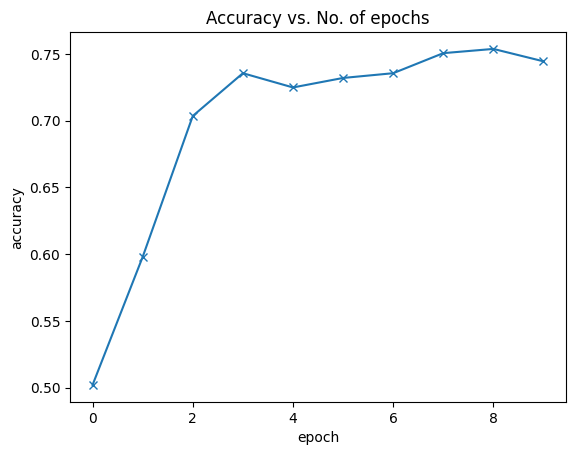

In [46]:
plot_accuracies(history)

In [47]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

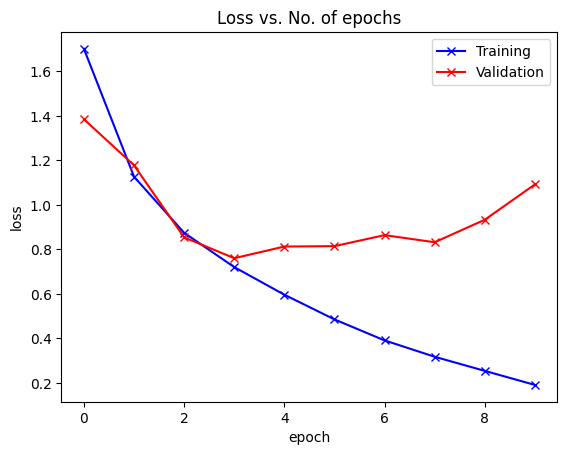

In [48]:
plot_losses(history)

In [49]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [50]:
def predict(img, model):
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return dataset.classes[preds[0].item()]

Label: airplane , Predicted: airplane


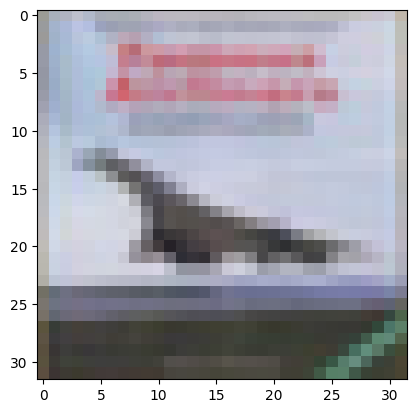

In [51]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict(img, model))

Label: automobile , Predicted: truck


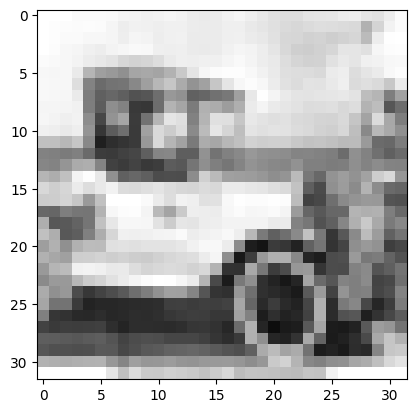

In [52]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, 64), device)
res = evaluate(model, test_loader)
res

In [ ]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')